<a href="https://colab.research.google.com/github/Deepti-Shringare/Downscaling_of_no2map_XGBoost/blob/main/COLAB_CODES/fishnet_prediction_OUTPUT_TO_GEE_VISUALIZARION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounted at /content/drive
✓ All libraries imported successfully


╔==============================================================================╗
║                                                                              ║
║                   AIR QUALITY NO₂ DOWNSCALING MODEL - DELHI                  ║
║                        39 Weather Stations | Daily Data                      ║
║                         TEMPORAL + SPATIAL VALIDATION                        ║
║                                                                              ║
╚==============================================================================╝

Start time: 2026-01-03 14:33:07

STEP 1: LOADING DATA
✓ Data loaded successfully
  - Rows: 14,274
  - Columns: 15
  - Stations: 39
✓ Date converted to datetime
  - Date range: 2024-01-01 00:00:00 to 2024-12-31 00:00:00
  - Total days: 365

✓ Sample of your data:
       station       lat        lon       date  groundtruth_no2  tropospheric_no2  population_density  

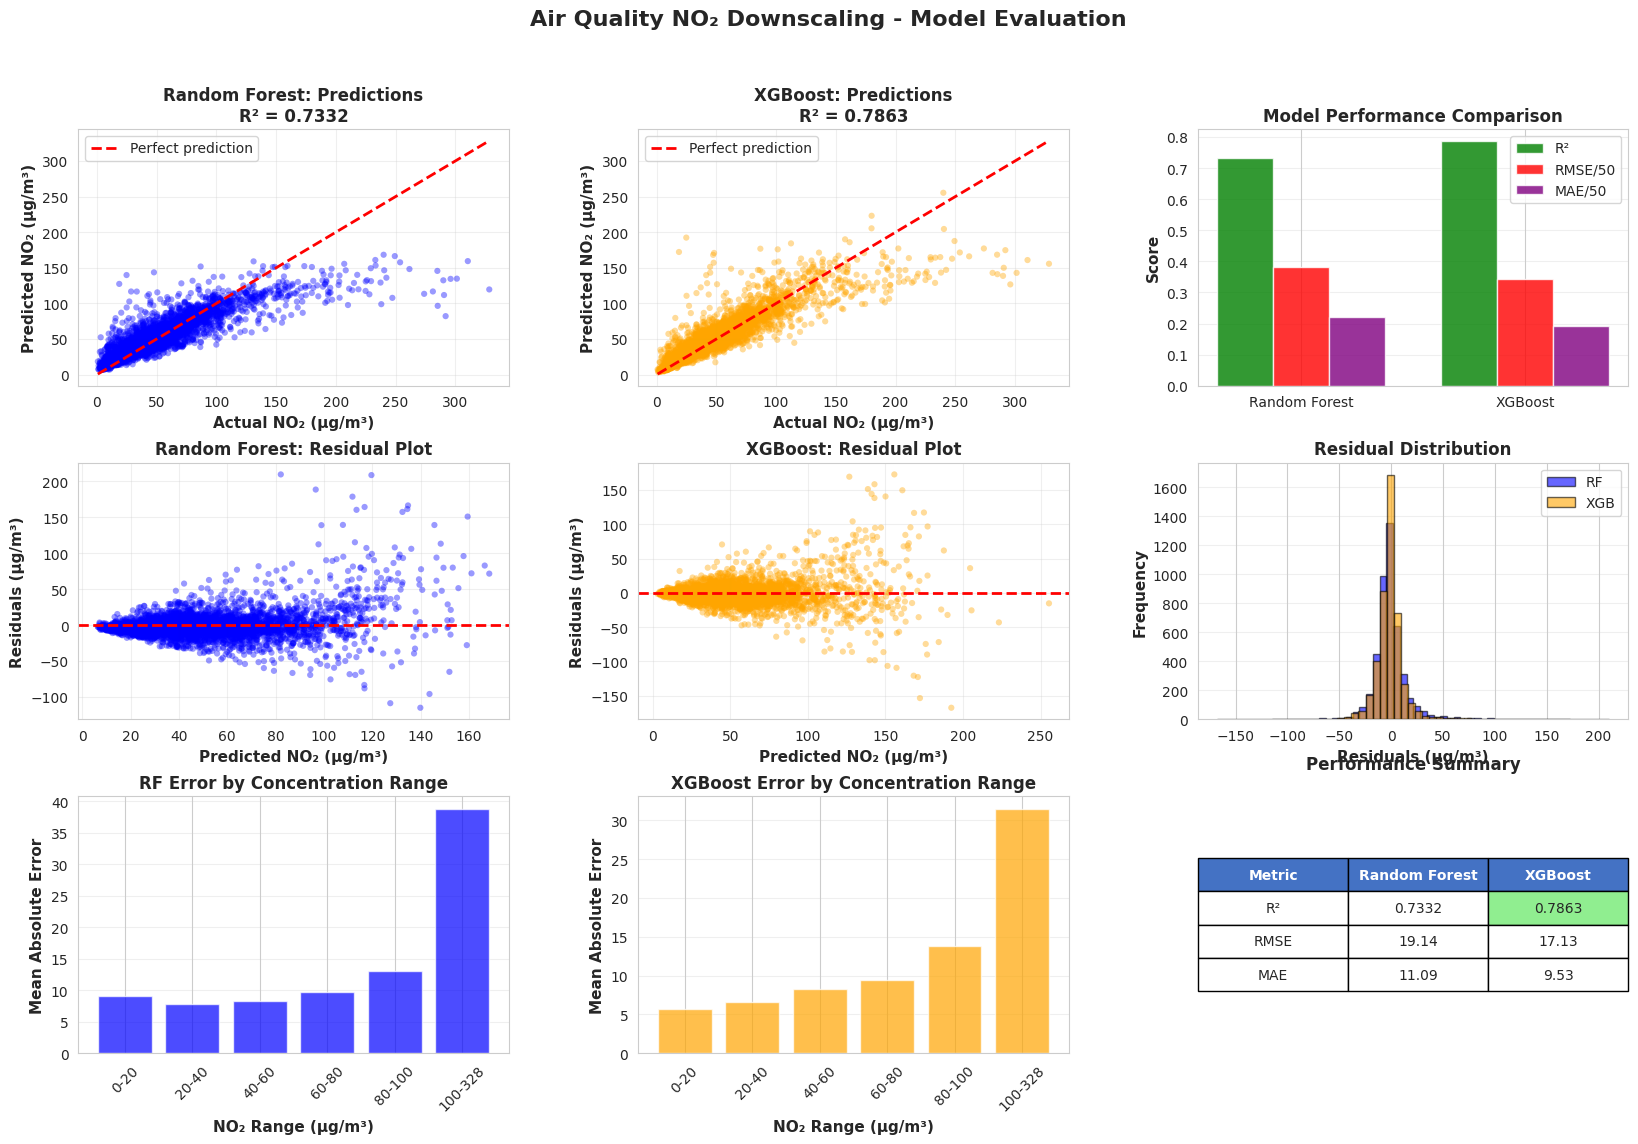

✓ Saved: random_forest_feature_importance.png


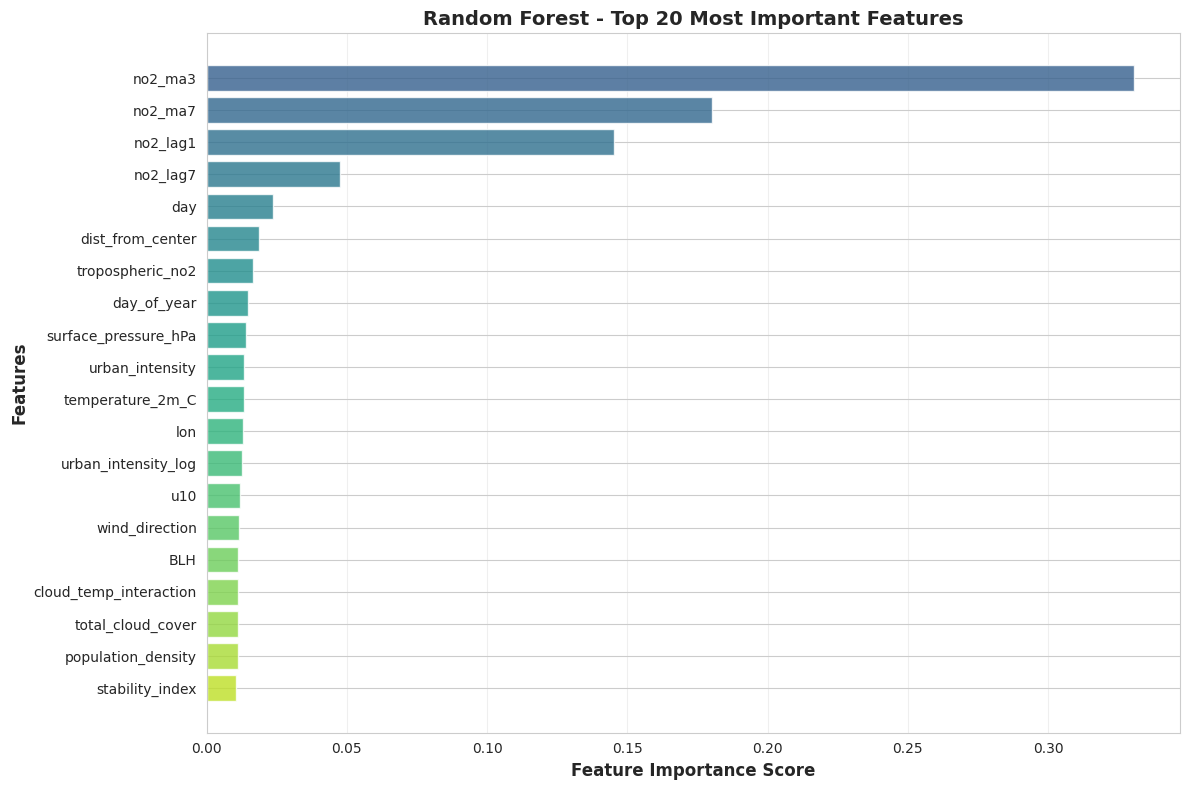


Top 10 features for Random Forest:
   1. no2_ma3                        : 0.3305
   2. no2_ma7                        : 0.1803
   3. no2_lag1                       : 0.1451
   4. no2_lag7                       : 0.0477
   5. day                            : 0.0238
   6. dist_from_center               : 0.0187
   7. tropospheric_no2               : 0.0166
   8. day_of_year                    : 0.0149
   9. surface_pressure_hPa           : 0.0142
  10. urban_intensity                : 0.0132
✓ Saved: xgboost_feature_importance.png


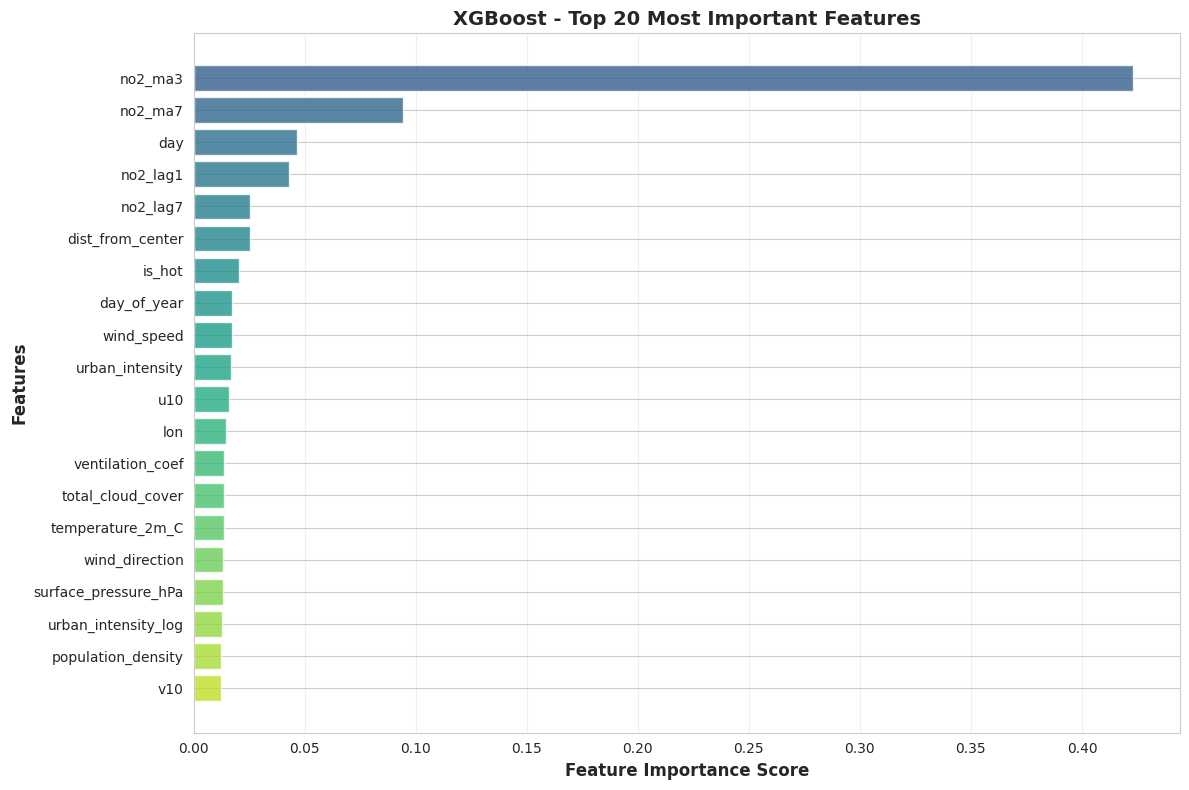


Top 10 features for XGBoost:
   1. no2_ma3                        : 0.4230
   2. no2_ma7                        : 0.0942
   3. day                            : 0.0464
   4. no2_lag1                       : 0.0429
   5. no2_lag7                       : 0.0256
   6. dist_from_center               : 0.0252
   7. is_hot                         : 0.0204
   8. day_of_year                    : 0.0174
   9. wind_speed                     : 0.0172
  10. urban_intensity                : 0.0170

STEP 7: SAVING MODELS TO GOOGLE DRIVE
✓ Saved: /content/drive/MyDrive/MAJOR_PROJECT/trained_models/random_forest_no2_model.pkl
✓ Saved: /content/drive/MyDrive/MAJOR_PROJECT/trained_models/xgboost_no2_model.pkl
✓ Saved: /content/drive/MyDrive/MAJOR_PROJECT/trained_models/test_station_info.pkl
✓ Saved: /content/drive/MyDrive/MAJOR_PROJECT/trained_models/test_station_info.json

✓ All models saved to Google Drive!

Location: /content/drive/MyDrive/MAJOR_PROJECT/trained_models

To load models later:
  import 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# ML Libraries
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb

print("✓ All libraries imported successfully")

# ============================================================================
# 1. DATA LOADING AND PREPROCESSING
# ============================================================================

def load_and_preprocess_data(filepath):
    """
    Load and preprocess the master dataset
    """
    print("\n" + "=" * 80)
    print("STEP 1: LOADING DATA")
    print("=" * 80)

    # Load data
    df = pd.read_csv(filepath)
    print(f"✓ Data loaded successfully")
    print(f"  - Rows: {df.shape[0]:,}")
    print(f"  - Columns: {df.shape[1]}")
    print(f"  - Stations: {df['station'].nunique()}")

    # Convert date to datetime
    df['date'] = pd.to_datetime(df['date'])
    print(f"✓ Date converted to datetime")
    print(f"  - Date range: {df['date'].min()} to {df['date'].max()}")
    print(f"  - Total days: {(df['date'].max() - df['date'].min()).days}")

    # Display first few rows
    print("\n✓ Sample of your data:")
    print(df.head(3).to_string())

    # Data quality check
    print("\n" + "-" * 80)
    print("DATA QUALITY CHECK")
    print("-" * 80)
    missing = df.isnull().sum()
    if missing.sum() > 0:
        print("Missing values found:")
        for col in missing[missing > 0].index:
            pct = (missing[col] / len(df)) * 100
            print(f"  - {col}: {missing[col]:,} ({pct:.1f}%)")
    else:
        print("✓ No missing values found!")

    return df

def handle_missing_values(df):
    """
    Handle missing values in the dataset
    Strategy: Use spatial-temporal averaging for satellite data gaps (clouds)
    """
    print("\n" + "=" * 80)
    print("STEP 2: HANDLING MISSING VALUES")
    print("=" * 80)

    initial_rows = len(df)

    # 1. Remove rows where target (groundtruth_no2) is missing
    df = df.dropna(subset=['groundtruth_no2'])
    removed = initial_rows - len(df)
    if removed > 0:
        print(f"✓ Removed {removed:,} rows with missing groundtruth_no2")
        print(f"  - Remaining rows: {len(df):,}")
    else:
        print("✓ No missing values in groundtruth_no2")

    # 2. Handle missing tropospheric_no2 (satellite data - gaps due to clouds)
    if df['tropospheric_no2'].isnull().sum() > 0:
        missing_count = df['tropospheric_no2'].isnull().sum()
        print(f"\n✓ Handling {missing_count:,} missing satellite values (cloudy days)")

        # Create indicator for missing satellite data
        df['satellite_missing_flag'] = df['tropospheric_no2'].isnull().astype(int)

        # Fill with station-month average (same location, same season)
        df['tropospheric_no2'] = df.groupby(['station', df['date'].dt.month])['tropospheric_no2'].transform(
            lambda x: x.fillna(x.mean())
        )

        # If still missing, use station average
        df['tropospheric_no2'] = df.groupby('station')['tropospheric_no2'].transform(
            lambda x: x.fillna(x.mean())
        )

        # If STILL missing (entire station has no data), use overall mean
        df['tropospheric_no2'].fillna(df['tropospheric_no2'].mean(), inplace=True)

        print(f"  - Filled using spatial-temporal averaging")
        print(f"  - Added 'satellite_missing_flag' feature")
    else:
        print("✓ No missing satellite data")
        df['satellite_missing_flag'] = 0

    # 3. Check for any remaining missing values in predictors
    predictor_cols = [col for col in df.columns if col not in ['station', 'date', 'groundtruth_no2']]
    remaining_missing = df[predictor_cols].isnull().sum().sum()

    if remaining_missing > 0:
        print(f"\n⚠ Warning: {remaining_missing} missing values in other features")
        print("  - Filling with column means...")
        df[predictor_cols] = df[predictor_cols].fillna(df[predictor_cols].mean())
        print("  ✓ All missing values handled")

    print(f"\n✓ Final dataset: {len(df):,} rows ready for modeling")

    return df

# ============================================================================
# 2. FEATURE ENGINEERING
# ============================================================================

def create_features(df):
    """
    Create additional features to boost model performance
    """
    print("\n" + "=" * 80)
    print("STEP 3: FEATURE ENGINEERING")
    print("=" * 80)

    initial_features = len(df.columns)

    # TEMPORAL FEATURES
    print("\n1. Creating temporal features...")
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['day_of_year'] = df['date'].dt.dayofyear
    df['day_of_week'] = df['date'].dt.dayofweek  # Monday=0, Sunday=6
    df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)

    # Season (important for Delhi's air quality)
    df['season'] = df['month'].apply(lambda x:
        'winter' if x in [12, 1, 2] else
        'spring' if x in [3, 4, 5] else
        'summer' if x in [6, 7, 8] else
        'autumn')

    # Convert season to numeric
    season_map = {'winter': 1, 'spring': 2, 'summer': 3, 'autumn': 4}
    df['season_numeric'] = df['season'].map(season_map)

    # Critical winter months (Nov-Feb) when Delhi has worst air quality
    df['is_critical_winter'] = df['month'].apply(lambda x: 1 if x in [11, 12, 1, 2] else 0)

    print(f"   ✓ Added 8 temporal features")

    # METEOROLOGICAL FEATURES
    print("\n2. Creating meteorological features...")

    # Wind direction (important for pollution transport)
    df['wind_direction'] = np.arctan2(df['v10'], df['u10']) * 180 / np.pi
    df['wind_direction'] = (df['wind_direction'] + 360) % 360  # Convert to 0-360

    # Atmospheric stability (higher = more stable = more pollution accumulation)
    df['stability_index'] = df['BLH'] / (df['wind_speed'] + 0.1)

    # Ventilation coefficient (BLH * wind_speed) - higher = better dispersion
    df['ventilation_coef'] = df['BLH'] * df['wind_speed']

    # Temperature categories (impacts chemical reactions)
    df['temp_category'] = pd.cut(df['temperature_2m_C'],
                                   bins=[-np.inf, 15, 25, np.inf],
                                   labels=['cold', 'moderate', 'hot'])
    df['is_cold'] = (df['temperature_2m_C'] < 15).astype(int)
    df['is_hot'] = (df['temperature_2m_C'] > 30).astype(int)

    print(f"   ✓ Added 7 meteorological features")

    # EMISSION PROXY FEATURES
    print("\n3. Creating emission proxy features...")

    # Population-nightlight interaction (urbanization intensity)
    df['urban_intensity'] = df['population_density'] * df['night_light']

    # Normalize for better scaling
    df['urban_intensity_log'] = np.log1p(df['urban_intensity'])

    print(f"   ✓ Added 2 emission proxy features")

    # SPATIAL FEATURES
    print("\n4. Creating spatial features...")

    # Distance from city center (approximate Delhi center: 28.6139°N, 77.2090°E)
    delhi_center_lat, delhi_center_lon = 28.6139, 77.2090
    df['dist_from_center'] = np.sqrt(
        (df['lat'] - delhi_center_lat)**2 +
        (df['lon'] - delhi_center_lon)**2
    ) * 111  # Convert to km (approximate)

    print(f"   ✓ Added 1 spatial feature")

    # TEMPORAL LAG FEATURES (previous days' pollution)
    print("\n5. Creating lag features...")
    df = df.sort_values(['station', 'date'])

    # Yesterday's NO2 (very predictive)
    df['no2_lag1'] = df.groupby('station')['groundtruth_no2'].shift(1)

    # Last week's NO2
    df['no2_lag7'] = df.groupby('station')['groundtruth_no2'].shift(7)

    # 3-day moving average
    df['no2_ma3'] = df.groupby('station')['groundtruth_no2'].transform(
        lambda x: x.rolling(window=3, min_periods=1).mean()
    )

    # 7-day moving average
    df['no2_ma7'] = df.groupby('station')['groundtruth_no2'].transform(
        lambda x: x.rolling(window=7, min_periods=1).mean()
    )

    print(f"   ✓ Added 4 lag features")

    # INTERACTION FEATURES
    print("\n6. Creating interaction features...")

    # Satellite * stability (trapped pollution)
    df['satellite_stability'] = df['tropospheric_no2'] * df['stability_index']

    # Cloudy + cold = worse air quality
    df['cloud_temp_interaction'] = df['total_cloud_cover'] * (1 / (df['temperature_2m_C'] + 1))

    print(f"   ✓ Added 2 interaction features")

    # SUMMARY
    final_features = len(df.columns)
    new_features = final_features - initial_features

    print("\n" + "-" * 80)
    print(f"✓ FEATURE ENGINEERING COMPLETE")
    print(f"  - Started with: {initial_features} columns")
    print(f"  - Created: {new_features} new features")
    print(f"  - Total features: {final_features} columns")
    print("-" * 80)

    return df

# ============================================================================
# 3. DATA PREPARATION
# ============================================================================

def prepare_train_test_split(df, random_state=42):
    """
    Prepare train-test split with TEMPORAL and SPATIAL validation

    TEMPORAL SPLIT:
    - Train: Months 3-11 (March to November)
    - Test: Months 12, 1, 2 (December, January, February - winter months)

    SPATIAL SPLIT:
    - Randomly select 5 stations for testing only (spatial generalization)
    - These stations never seen during training
    """
    print("\n" + "=" * 80)
    print("STEP 4: PREPARING TRAIN-TEST SPLIT")
    print("=" * 80)
    print("\n⚠️  ADVANCED VALIDATION STRATEGY:")
    print("   1. TEMPORAL SPLIT: Train on Mar-Nov, Test on Dec-Feb (winter)")
    print("   2. SPATIAL SPLIT: 5 stations held out for testing")
    print("=" * 80)

    # Define features to EXCLUDE from modeling
    exclude_cols = [
        'station', 'date', 'groundtruth_no2',  # Identifiers and target
        'season', 'temp_category'  # Categorical (already have numeric versions)
    ]

    # Get all feature columns
    feature_cols = [col for col in df.columns if col not in exclude_cols]

    print(f"\n✓ Selected {len(feature_cols)} features for modeling")
    print("\nFeature categories:")

    # Categorize features for better understanding
    temporal_features = [f for f in feature_cols if any(x in f for x in ['year', 'month', 'day', 'season', 'weekend', 'winter'])]
    meteo_features = [f for f in feature_cols if any(x in f for x in ['wind', 'temp', 'pressure', 'BLH', 'cloud', 'stability', 'ventilation'])]
    spatial_features = [f for f in feature_cols if any(x in f for x in ['lat', 'lon', 'dist', 'population', 'night', 'urban'])]
    satellite_features = [f for f in feature_cols if 'tropospheric' in f or 'satellite' in f]
    lag_features = [f for f in feature_cols if 'lag' in f or 'ma' in f]

    print(f"  - Temporal: {len(temporal_features)}")
    print(f"  - Meteorological: {len(meteo_features)}")
    print(f"  - Spatial/Emission: {len(spatial_features)}")
    print(f"  - Satellite: {len(satellite_features)}")
    print(f"  - Lag/Moving Avg: {len(lag_features)}")

    # Remove rows with NaN values (mainly from lag features)
    df_clean = df.dropna()
    removed_rows = len(df) - len(df_clean)
    if removed_rows > 0:
        print(f"\n✓ Removed {removed_rows:,} rows with NaN (from lag features)")

    # ==========================================================================
    # STEP 1: SPATIAL SPLIT - Select 5 test-only stations
    # ==========================================================================
    print("\n" + "-" * 80)
    print("SPATIAL SPLIT: Selecting test-only stations")
    print("-" * 80)

    all_stations = df_clean['station'].unique()
    np.random.seed(random_state)
    test_stations = np.random.choice(all_stations, size=5, replace=False)

    print(f"✓ Total stations: {len(all_stations)}")
    print(f"✓ Stations reserved for TESTING ONLY:")
    for i, station in enumerate(test_stations, 1):
        print(f"   {i}. {station}")

    # Split data by stations
    spatial_test_mask = df_clean['station'].isin(test_stations)
    spatial_train_mask = ~spatial_test_mask

    df_spatial_train = df_clean[spatial_train_mask].copy()
    df_spatial_test = df_clean[spatial_test_mask].copy()

    print(f"\n✓ Spatial split complete:")
    print(f"   - Training stations: {df_spatial_train['station'].nunique()}")
    print(f"   - Testing stations: {df_spatial_test['station'].nunique()}")

    # ==========================================================================
    # STEP 2: TEMPORAL SPLIT - Train on Mar-Nov, Test on Dec-Feb
    # ==========================================================================
    print("\n" + "-" * 80)
    print("TEMPORAL SPLIT: Train on Mar-Nov, Test on Dec-Feb")
    print("-" * 80)

    # For training stations: split by months
    train_months = [3, 4, 5, 6, 7, 8, 9, 10, 11]  # Mar-Nov
    test_months = [12, 1, 2]  # Dec-Feb (winter)

    temporal_train_mask = df_spatial_train['month'].isin(train_months)
    temporal_test_mask = df_spatial_train['month'].isin(test_months)

    df_temporal_train = df_spatial_train[temporal_train_mask].copy()
    df_temporal_test_same_stations = df_spatial_train[temporal_test_mask].copy()

    # Combine test sets:
    # 1. Temporal test (winter months from training stations)
    # 2. Spatial test (all months from test-only stations)
    df_test_combined = pd.concat([df_temporal_test_same_stations, df_spatial_test], axis=0)

    print(f"✓ Temporal split for training stations:")
    print(f"   - Training: {len(df_temporal_train):,} samples (Mar-Nov)")
    print(f"   - Testing: {len(df_temporal_test_same_stations):,} samples (Dec-Feb)")

    print(f"\n✓ Combined test set:")
    print(f"   - Temporal test (winter, training stations): {len(df_temporal_test_same_stations):,}")
    print(f"   - Spatial test (all months, test stations): {len(df_spatial_test):,}")
    print(f"   - Total test samples: {len(df_test_combined):,}")

    # ==========================================================================
    # STEP 3: Prepare X and y
    # ==========================================================================
    print("\n" + "-" * 80)
    print("FINAL DATASET SUMMARY")
    print("-" * 80)

    X_train = df_temporal_train[feature_cols]
    y_train = df_temporal_train['groundtruth_no2']

    X_test = df_test_combined[feature_cols]
    y_test = df_test_combined['groundtruth_no2']

    print(f"\n✓ TRAINING SET:")
    print(f"   - Samples: {len(X_train):,}")
    print(f"   - Stations: {df_temporal_train['station'].nunique()}")
    print(f"   - Months: Mar-Nov (3-11)")
    print(f"   - NO2 range: {y_train.min():.2f} to {y_train.max():.2f} µg/m³")
    print(f"   - NO2 mean: {y_train.mean():.2f} µg/m³")

    print(f"\n✓ TESTING SET:")
    print(f"   - Samples: {len(X_test):,}")
    print(f"   - Test ratio: {len(X_test)/(len(X_train)+len(X_test))*100:.1f}%")
    print(f"   - Contains:")
    print(f"     • Temporal test: winter months (Dec-Feb) from training stations")
    print(f"     • Spatial test: ALL months from 5 unseen stations")
    print(f"   - NO2 range: {y_test.min():.2f} to {y_test.max():.2f} µg/m³")
    print(f"   - NO2 mean: {y_test.mean():.2f} µg/m³")

    print("\n" + "=" * 80)
    print("✓ DATA SPLIT COMPLETE - NO DATA LEAKAGE GUARANTEED")
    print("=" * 80)

    # Store test station info for later reference
    test_station_info = {
        'test_stations': test_stations.tolist(),
        'train_stations': df_temporal_train['station'].unique().tolist()
    }

    return X_train, X_test, y_train, y_test, feature_cols, test_station_info

# ============================================================================
# 4. RANDOM FOREST MODEL
# ============================================================================

def train_random_forest(X_train, y_train, X_test, y_test):
    """
    Train Random Forest model
    """
    print("\n" + "=" * 80)
    print("STEP 5A: TRAINING RANDOM FOREST MODEL")
    print("=" * 80)

    # Define model
    rf_model = RandomForestRegressor(
        n_estimators=200,      # Number of trees
        max_depth=20,          # Maximum tree depth
        min_samples_split=5,   # Min samples to split node
        min_samples_leaf=2,    # Min samples in leaf
        max_features='sqrt',   # Features to consider for split
        random_state=42,
        n_jobs=-1,             # Use all CPU cores
        verbose=0
    )

    print("Training Random Forest...")
    print("  - Trees: 200")
    print("  - Max depth: 20")
    print("  - This may take 1-3 minutes...\n")

    rf_model.fit(X_train, y_train)

    # Predictions
    y_pred_train = rf_model.predict(X_train)
    y_pred_test = rf_model.predict(X_test)

    # Evaluation metrics
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    test_mae = mean_absolute_error(y_test, y_pred_test)

    print("✓ Training complete!\n")
    print("-" * 80)
    print("RANDOM FOREST PERFORMANCE")
    print("-" * 80)
    print(f"Training R²:    {train_r2:.4f}")
    print(f"Testing R²:     {test_r2:.4f}  ⭐")
    print(f"Training RMSE:  {train_rmse:.4f} µg/m³")
    print(f"Testing RMSE:   {test_rmse:.4f} µg/m³  ⭐")
    print(f"Testing MAE:    {test_mae:.4f} µg/m³  ⭐")

    # Interpretation
    print("\nInterpretation:")
    if test_r2 > 0.75:
        print("  ✓ EXCELLENT - Model explains >75% of variance")
    elif test_r2 > 0.65:
        print("  ✓ GOOD - Model explains >65% of variance")
    else:
        print("  ⚠ FAIR - Consider feature engineering or hyperparameter tuning")

    return rf_model, y_pred_test

# ============================================================================
# 5. XGBOOST MODEL
# ============================================================================

def train_xgboost(X_train, y_train, X_test, y_test):
    """
    Train XGBoost model
    """
    print("\n" + "=" * 80)
    print("STEP 5B: TRAINING XGBOOST MODEL")
    print("=" * 80)

    # Define model
    xgb_model = xgb.XGBRegressor(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=8,
        min_child_weight=3,
        subsample=0.8,
        colsample_bytree=0.8,
        gamma=0.1,
        random_state=42,
        n_jobs=-1,
        verbosity=0
    )

    print("Training XGBoost...")
    print("  - Trees: 200")
    print("  - Learning rate: 0.05")
    print("  - This may take 1-3 minutes...\n")

    xgb_model.fit(X_train, y_train)

    # Predictions
    y_pred_train = xgb_model.predict(X_train)
    y_pred_test = xgb_model.predict(X_test)

    # Evaluation metrics
    train_r2 = r2_score(y_train, y_pred_train)
    test_r2 = r2_score(y_test, y_pred_test)
    train_rmse = np.sqrt(mean_squared_error(y_train, y_pred_train))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))
    test_mae = mean_absolute_error(y_test, y_pred_test)

    print("✓ Training complete!\n")
    print("-" * 80)
    print("XGBOOST PERFORMANCE")
    print("-" * 80)
    print(f"Training R²:    {train_r2:.4f}")
    print(f"Testing R²:     {test_r2:.4f}  ⭐")
    print(f"Training RMSE:  {train_rmse:.4f} µg/m³")
    print(f"Testing RMSE:   {test_rmse:.4f} µg/m³  ⭐")
    print(f"Testing MAE:    {test_mae:.4f} µg/m³  ⭐")

    # Interpretation
    print("\nInterpretation:")
    if test_r2 > 0.75:
        print("  ✓ EXCELLENT - Model explains >75% of variance")
    elif test_r2 > 0.65:
        print("  ✓ GOOD - Model explains >65% of variance")
    else:
        print("  ⚠ FAIR - Consider feature engineering or hyperparameter tuning")

    return xgb_model, y_pred_test

# ============================================================================
# 6. VISUALIZATION
# ============================================================================

def plot_comprehensive_results(y_test, y_pred_rf, y_pred_xgb):
    """
    Create comprehensive visualizations
    """
    print("\n" + "=" * 80)
    print("STEP 6: GENERATING VISUALIZATIONS")
    print("=" * 80)

    # Set style
    sns.set_style("whitegrid")

    fig = plt.figure(figsize=(20, 12))
    gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

    # 1. Random Forest: Actual vs Predicted
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.scatter(y_test, y_pred_rf, alpha=0.4, s=20, c='blue', edgecolors='none')
    ax1.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
             'r--', lw=2, label='Perfect prediction')
    ax1.set_xlabel('Actual NO₂ (µg/m³)', fontsize=11, fontweight='bold')
    ax1.set_ylabel('Predicted NO₂ (µg/m³)', fontsize=11, fontweight='bold')
    ax1.set_title(f'Random Forest: Predictions\nR² = {r2_score(y_test, y_pred_rf):.4f}',
                  fontsize=12, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # 2. XGBoost: Actual vs Predicted
    ax2 = fig.add_subplot(gs[0, 1])
    ax2.scatter(y_test, y_pred_xgb, alpha=0.4, s=20, c='orange', edgecolors='none')
    ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],
             'r--', lw=2, label='Perfect prediction')
    ax2.set_xlabel('Actual NO₂ (µg/m³)', fontsize=11, fontweight='bold')
    ax2.set_ylabel('Predicted NO₂ (µg/m³)', fontsize=11, fontweight='bold')
    ax2.set_title(f'XGBoost: Predictions\nR² = {r2_score(y_test, y_pred_xgb):.4f}',
                  fontsize=12, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    # 3. Model Comparison Bar Chart
    ax3 = fig.add_subplot(gs[0, 2])
    metrics = {
        'R²': [r2_score(y_test, y_pred_rf), r2_score(y_test, y_pred_xgb)],
        'RMSE': [np.sqrt(mean_squared_error(y_test, y_pred_rf)),
                 np.sqrt(mean_squared_error(y_test, y_pred_xgb))],
        'MAE': [mean_absolute_error(y_test, y_pred_rf),
                mean_absolute_error(y_test, y_pred_xgb)]
    }

    x = np.arange(2)
    width = 0.25

    ax3.bar(x - width, metrics['R²'], width, label='R²', alpha=0.8, color='green')
    ax3.bar(x, [r/50 for r in metrics['RMSE']], width, label='RMSE/50', alpha=0.8, color='red')
    ax3.bar(x + width, [m/50 for m in metrics['MAE']], width, label='MAE/50', alpha=0.8, color='purple')
    ax3.set_ylabel('Score', fontsize=11, fontweight='bold')
    ax3.set_title('Model Performance Comparison', fontsize=12, fontweight='bold')
    ax3.set_xticks(x)
    ax3.set_xticklabels(['Random Forest', 'XGBoost'])
    ax3.legend()
    ax3.grid(True, alpha=0.3, axis='y')

    # 4. RF Residuals
    residuals_rf = y_test - y_pred_rf
    ax4 = fig.add_subplot(gs[1, 0])
    ax4.scatter(y_pred_rf, residuals_rf, alpha=0.4, s=20, c='blue', edgecolors='none')
    ax4.axhline(y=0, color='r', linestyle='--', lw=2)
    ax4.set_xlabel('Predicted NO₂ (µg/m³)', fontsize=11, fontweight='bold')
    ax4.set_ylabel('Residuals (µg/m³)', fontsize=11, fontweight='bold')
    ax4.set_title('Random Forest: Residual Plot', fontsize=12, fontweight='bold')
    ax4.grid(True, alpha=0.3)

    # 5. XGBoost Residuals
    residuals_xgb = y_test - y_pred_xgb
    ax5 = fig.add_subplot(gs[1, 1])
    ax5.scatter(y_pred_xgb, residuals_xgb, alpha=0.4, s=20, c='orange', edgecolors='none')
    ax5.axhline(y=0, color='r', linestyle='--', lw=2)
    ax5.set_xlabel('Predicted NO₂ (µg/m³)', fontsize=11, fontweight='bold')
    ax5.set_ylabel('Residuals (µg/m³)', fontsize=11, fontweight='bold')
    ax5.set_title('XGBoost: Residual Plot', fontsize=12, fontweight='bold')
    ax5.grid(True, alpha=0.3)

    # 6. Residual Distribution Comparison
    ax6 = fig.add_subplot(gs[1, 2])
    ax6.hist(residuals_rf, bins=50, alpha=0.6, label='RF', color='blue', edgecolor='black')
    ax6.hist(residuals_xgb, bins=50, alpha=0.6, label='XGB', color='orange', edgecolor='black')
    ax6.set_xlabel('Residuals (µg/m³)', fontsize=11, fontweight='bold')
    ax6.set_ylabel('Frequency', fontsize=11, fontweight='bold')
    ax6.set_title('Residual Distribution', fontsize=12, fontweight='bold')
    ax6.legend()
    ax6.grid(True, alpha=0.3, axis='y')

    # 7. Error Distribution by Range (RF)
    ax7 = fig.add_subplot(gs[2, 0])
    bins = [0, 20, 40, 60, 80, 100, y_test.max()]
    y_test_binned = pd.cut(y_test, bins=bins)
    errors_by_bin_rf = [np.abs(residuals_rf[y_test_binned == b]).mean()
                         for b in y_test_binned.cat.categories]
    ax7.bar(range(len(errors_by_bin_rf)), errors_by_bin_rf, alpha=0.7, color='blue')
    ax7.set_xlabel('NO₂ Range (µg/m³)', fontsize=11, fontweight='bold')
    ax7.set_ylabel('Mean Absolute Error', fontsize=11, fontweight='bold')
    ax7.set_title('RF Error by Concentration Range', fontsize=12, fontweight='bold')
    ax7.set_xticks(range(len(errors_by_bin_rf)))
    ax7.set_xticklabels([f'{int(b.left)}-{int(b.right)}' for b in y_test_binned.cat.categories],
                         rotation=45)
    ax7.grid(True, alpha=0.3, axis='y')

    # 8. Error Distribution by Range (XGB)
    ax8 = fig.add_subplot(gs[2, 1])
    errors_by_bin_xgb = [np.abs(residuals_xgb[y_test_binned == b]).mean()
                          for b in y_test_binned.cat.categories]
    ax8.bar(range(len(errors_by_bin_xgb)), errors_by_bin_xgb, alpha=0.7, color='orange')
    ax8.set_xlabel('NO₂ Range (µg/m³)', fontsize=11, fontweight='bold')
    ax8.set_ylabel('Mean Absolute Error', fontsize=11, fontweight='bold')
    ax8.set_title('XGBoost Error by Concentration Range', fontsize=12, fontweight='bold')
    ax8.set_xticks(range(len(errors_by_bin_xgb)))
    ax8.set_xticklabels([f'{int(b.left)}-{int(b.right)}' for b in y_test_binned.cat.categories],
                         rotation=45)
    ax8.grid(True, alpha=0.3, axis='y')

    # 9. Performance Summary Table
    ax9 = fig.add_subplot(gs[2, 2])
    ax9.axis('off')

    summary_data = [
        ['Metric', 'Random Forest', 'XGBoost'],
        ['R²', f"{r2_score(y_test, y_pred_rf):.4f}", f"{r2_score(y_test, y_pred_xgb):.4f}"],
        ['RMSE', f"{np.sqrt(mean_squared_error(y_test, y_pred_rf)):.2f}",
         f"{np.sqrt(mean_squared_error(y_test, y_pred_xgb)):.2f}"],
        ['MAE', f"{mean_absolute_error(y_test, y_pred_rf):.2f}",
         f"{mean_absolute_error(y_test, y_pred_xgb):.2f}"]
    ]

    table = ax9.table(cellText=summary_data, cellLoc='center', loc='center',
                      colWidths=[0.35, 0.325, 0.325])
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1, 2)

    # Style header row
    for i in range(3):
        table[(0, i)].set_facecolor('#4472C4')
        table[(0, i)].set_text_props(weight='bold', color='white')

    # Highlight better scores
    rf_r2 = r2_score(y_test, y_pred_rf)
    xgb_r2 = r2_score(y_test, y_pred_xgb)
    if rf_r2 > xgb_r2:
        table[(1, 1)].set_facecolor('#90EE90')
    else:
        table[(1, 2)].set_facecolor('#90EE90')

    ax9.set_title('Performance Summary', fontsize=12, fontweight='bold', pad=20)

    plt.suptitle('Air Quality NO₂ Downscaling - Model Evaluation',
                 fontsize=16, fontweight='bold', y=0.98)

    plt.savefig('model_evaluation_comprehensive.png', dpi=300, bbox_inches='tight')
    print("✓ Saved: model_evaluation_comprehensive.png")
    plt.show()

def plot_feature_importance(model, feature_names, model_name='Model', top_n=20):
    """
    Plot feature importance
    """
    importances = model.feature_importances_
    indices = np.argsort(importances)[::-1][:top_n]

    plt.figure(figsize=(12, 8))
    colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(indices)))

    plt.barh(range(len(indices)), importances[indices], color=colors, alpha=0.8)
    plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
    plt.xlabel('Feature Importance Score', fontsize=12, fontweight='bold')
    plt.ylabel('Features', fontsize=12, fontweight='bold')
    plt.title(f'{model_name} - Top {top_n} Most Important Features',
              fontsize=14, fontweight='bold')
    plt.gca().invert_yaxis()
    plt.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()

    filename = f'{model_name.lower().replace(" ", "_")}_feature_importance.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"✓ Saved: {filename}")
    plt.show()

    # Print top 10
    print(f"\nTop 10 features for {model_name}:")
    for i, idx in enumerate(indices[:10], 1):
        print(f"  {i:2d}. {feature_names[idx]:30s} : {importances[idx]:.4f}")

# ============================================================================
# 7. SAVE MODEL
# ============================================================================

def save_models(rf_model, xgb_model, test_station_info):
    """
    Save trained models to Google Drive
    """
    import pickle

    print("\n" + "=" * 80)
    print("STEP 7: SAVING MODELS TO GOOGLE DRIVE")
    print("=" * 80)

    # Create directory if it doesn't exist
    save_dir = '/content/drive/MyDrive/MAJOR_PROJECT/trained_models'
    import os
    os.makedirs(save_dir, exist_ok=True)

    # Save Random Forest
    rf_path = f'{save_dir}/random_forest_no2_model.pkl'
    with open(rf_path, 'wb') as f:
        pickle.dump(rf_model, f)
    print(f"✓ Saved: {rf_path}")

    # Save XGBoost
    xgb_path = f'{save_dir}/xgboost_no2_model.pkl'
    with open(xgb_path, 'wb') as f:
        pickle.dump(xgb_model, f)
    print(f"✓ Saved: {xgb_path}")

    # Save test station info
    info_path = f'{save_dir}/test_station_info.pkl'
    with open(info_path, 'wb') as f:
        pickle.dump(test_station_info, f)
    print(f"✓ Saved: {info_path}")

    # Save as JSON for easy reading
    import json
    json_path = f'{save_dir}/test_station_info.json'
    with open(json_path, 'w') as f:
        json.dump(test_station_info, f, indent=2)
    print(f"✓ Saved: {json_path}")

    print("\n✓ All models saved to Google Drive!")
    print(f"\nLocation: {save_dir}")
    print("\nTo load models later:")
    print("  import pickle")
    print(f"  with open('{rf_path}', 'rb') as f:")
    print("      rf_model = pickle.load(f)")

    print("\n📊 Test Station Info:")
    print(f"   - Test-only stations: {test_station_info['test_stations']}")
    print(f"   - Training stations: {len(test_station_info['train_stations'])} stations")

# ============================================================================
# 8. MAIN EXECUTION PIPELINE
# ============================================================================

def main(filepath):
    """
    Main execution pipeline - Run everything
    """
    print("\n")
    print("╔" + "=" * 78 + "╗")
    print("║" + " " * 78 + "║")
    print("║" + "  AIR QUALITY NO₂ DOWNSCALING MODEL - DELHI".center(78) + "║")
    print("║" + "  39 Weather Stations | Daily Data".center(78) + "║")
    print("║" + "  TEMPORAL + SPATIAL VALIDATION".center(78) + "║")
    print("║" + " " * 78 + "║")
    print("╚" + "=" * 78 + "╝")
    print(f"\nStart time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

    # Execute pipeline
    df = load_and_preprocess_data(filepath)
    df = handle_missing_values(df)
    df = create_features(df)
    X_train, X_test, y_train, y_test, feature_cols, test_station_info = prepare_train_test_split(df)

    rf_model, y_pred_rf = train_random_forest(X_train, y_train, X_test, y_test)
    xgb_model, y_pred_xgb = train_xgboost(X_train, y_train, X_test, y_test)

    plot_comprehensive_results(y_test, y_pred_rf, y_pred_xgb)
    plot_feature_importance(rf_model, feature_cols, 'Random Forest')
    plot_feature_importance(xgb_model, feature_cols, 'XGBoost')

    save_models(rf_model, xgb_model, test_station_info)

    # Final summary
    print("\n" + "=" * 80)
    print("PIPELINE COMPLETED SUCCESSFULLY! 🎉")
    print("=" * 80)
    print(f"End time: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
    print("\n✓ Models trained with TEMPORAL + SPATIAL validation")
    print("✓ Visualizations saved")
    print("✓ Models saved to Google Drive")

    print("\n" + "=" * 80)
    print("VALIDATION STRATEGY SUMMARY:")
    print("=" * 80)
    print("✓ TEMPORAL: Train on Mar-Nov, Test on Dec-Feb (winter)")
    print("✓ SPATIAL: 5 stations held out completely")
    print("✓ NO DATA LEAKAGE - Robust validation!")

    print("\nRecommendation:")
    rf_r2 = r2_score(y_test, y_pred_rf)
    xgb_r2 = r2_score(y_test, y_pred_xgb)
    if xgb_r2 > rf_r2:
        print("  → Use XGBoost model (better performance)")
    else:
        print("  → Use Random Forest model (better performance)")

    print("\n📍 Test Stations (never seen during training):")
    for station in test_station_info['test_stations']:
        print(f"   • {station}")

    return rf_model, xgb_model, feature_cols, X_train, X_test, y_train, y_test, test_station_info

# ============================================================================
# 9. USAGE INSTRUCTIONS
# ============================================================================

"""
HOW TO USE IN GOOGLE COLAB:
============================

1. Install required packages (run once):
   !pip install xgboost scikit-learn pandas numpy matplotlib seaborn

2. Upload your CSV file OR mount Google Drive:
   from google.colab import files
   uploaded = files.upload()  # Then select your CSV

   OR

   from google.colab import drive
   drive.mount('/content/drive')

3. Run the pipeline:
   filepath = 'your_file.csv'  # or '/content/drive/MyDrive/your_file.csv'
   rf_model, xgb_model, features, X_train, X_test, y_train, y_test = main(filepath)

4. Make predictions on new data:
   new_predictions = xgb_model.predict(X_new)

EXPECTED OUTPUTS:
=================
- model_evaluation_comprehensive.png (main results)
- random_forest_feature_importance.png
- xgboost_feature_importance.png
- random_forest_no2_model.pkl (saved model)
- xgboost_no2_model.pkl (saved model)
"""

# Run the pipeline
if __name__ == "__main__":
    # UPDATE THIS PATH TO YOUR CSV FILE
    filepath = '/content/drive/MyDrive/MAJOR_PROJECT/MASTERDATASET_39.csv'

    # Run everything
    rf_model, xgb_model, features, X_train, X_test, y_train, y_test, test_station_info = main(filepath)

ABOVE IS THE MODEL TRAINIG CODE


FISHNET IMPROVISATION

In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

FISHNET_PATH = "/content/drive/MyDrive/MAJOR_PROJECT/Delhi_500m_ML_Ready_2024.csv"

df = pd.read_csv(FISHNET_PATH)
df['date'] = pd.to_datetime(df['date'])

df = df.sort_values(['cell_id', 'date']).reset_index(drop=True)

print(df.shape)
df.head()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(2198196, 19)


,system:index,BLH,cell_id,date,first,lat,lon,month,night_light,population_density,surface_pressure_hPa,temperature_C,total_cloud_cover,tropospheric_no2,u10,v10,wind_speed,year,.geo
0,0_00000000000000000000,212.400391,13595006321,2024-01-01,1,28.561197,76.837604,1,3.220213,6.89673,992.680439,10.433005,0.226123,0.000143,0.476016,-0.954239,1.066379,2024,"{""type"":""Polygon"",""coordinates"":[[[76.83501103..."
1,1_00000000000000000000,169.765030,13595006321,2024-01-02,1,28.561197,76.837604,1,3.220213,6.89673,992.048162,9.901627,0.327535,0.000143,0.163960,-0.925008,0.939427,2024,"{""type"":""Polygon"",""coordinates"":[[[76.83501103..."
2,2_00000000000000000000,207.187027,13595006321,2024-01-03,1,28.561197,76.837604,1,3.220213,6.89673,991.770244,10.225144,0.367242,0.000125,0.464020,-0.865801,0.982307,2024,"{""type"":""Polygon"",""coordinates"":[[[76.83501103..."
3,3_00000000000000000000,257.212097,13595006321,2024-01-04,1,28.561197,76.837604,1,3.220213,6.89673,991.979320,12.448014,0.761316,0.000107,0.697372,-1.086230,1.290822,2024,"{""type"":""Polygon"",""coordinates"":[[[76.83501103..."
4,4_00000000000000000000,273.490631,13595006321,2024-01-05,1,28.561197,76.837604,1,3.220213,6.89673,992.457235,13.663892,0.974290,0.000088,0.322171,-0.670491,0.743876,2024,"{""type"":""Polygon"",""coordinates"":[[[76.83501103..."


In [ ]:
print([c for c in df.columns if 'tropospheric_no2' in c.lower()])


['tropospheric_no2']


In [ ]:
NO2_COL = "tropospheric_no2"


In [ ]:
# Lag days
LAGS = [1, 3, 7]

for lag in LAGS:
    df[f'no2_lag_{lag}'] = (
        df.groupby('cell_id')[NO2_COL]
          .shift(lag)
    )

df.head(10)


,system:index,BLH,cell_id,date,first,lat,lon,month,night_light,population_density,...,total_cloud_cover,tropospheric_no2,u10,v10,wind_speed,year,.geo,no2_lag_1,no2_lag_3,no2_lag_7
0,0_00000000000000000000,212.400391,13595006321,2024-01-01,1,28.561197,76.837604,1,3.220213,6.89673,...,0.226123,0.000143,0.476016,-0.954239,1.066379,2024,"{""type"":""Polygon"",""coordinates"":[[[76.83501103...",NaN,NaN,NaN
1,1_00000000000000000000,169.765030,13595006321,2024-01-02,1,28.561197,76.837604,1,3.220213,6.89673,...,0.327535,0.000143,0.163960,-0.925008,0.939427,2024,"{""type"":""Polygon"",""coordinates"":[[[76.83501103...",0.000143,NaN,NaN
2,2_00000000000000000000,207.187027,13595006321,2024-01-03,1,28.561197,76.837604,1,3.220213,6.89673,...,0.367242,0.000125,0.464020,-0.865801,0.982307,2024,"{""type"":""Polygon"",""coordinates"":[[[76.83501103...",0.000143,NaN,NaN
3,3_00000000000000000000,257.212097,13595006321,2024-01-04,1,28.561197,76.837604,1,3.220213,6.89673,...,0.761316,0.000107,0.697372,-1.086230,1.290822,2024,"{""type"":""Polygon"",""coordinates"":[[[76.83501103...",0.000125,0.000143,NaN
4,4_00000000000000000000,273.490631,13595006321,2024-01-05,1,28.561197,76.837604,1,3.220213,6.89673,...,0.974290,0.000088,0.322171,-0.670491,0.743876,2024,"{""type"":""Polygon"",""coordinates"":[[[76.83501103...",0.000107,0.000143,NaN
5,5_00000000000000000000,368.585510,13595006321,2024-01-06,1,28.561197,76.837604,1,3.220213,6.89673,...,0.500403,0.000070,0.427197,-1.124582,1.202989,2024,"{""type"":""Polygon"",""coordinates"":[[[76.83501103...",0.000088,0.000125,NaN
6,6_00000000000000000000,198.801529,13595006321,2024-01-07,1,28.561197,76.837604,1,3.220213,6.89673,...,0.290733,0.000052,-0.129390,0.283403,0.311543,2024,"{""type"":""Polygon"",""coordinates"":[[[76.83501103...",0.000070,0.000107,NaN
7,7_00000000000000000000,211.518356,13595006321,2024-01-08,1,28.561197,76.837604,1,3.220213,6.89673,...,0.052462,0.000058,-0.230935,-0.838064,0.869300,2024,"{""type"":""Polygon"",""coordinates"":[[[76.83501103...",0.000052,0.000088,0.000143
8,8_00000000000000000000,281.691467,13595006321,2024-01-09,1,28.561197,76.837604,1,3.220213,6.89673,...,0.083856,0.000064,1.539075,-1.805284,2.372299,2024,"{""type"":""Polygon"",""coordinates"":[[[76.83501103...",0.000058,0.000070,0.000143
9,9_00000000000000000000,220.547546,13595006321,2024-01-10,1,28.561197,76.837604,1,3.220213,6.89673,...,0.112871,0.000070,2.580599,-0.984114,2.761878,2024,"{""type"":""Polygon"",""coordinates"":[[[76.83501103...",0.000064,0.000052,0.000125


In [ ]:
df_lagged = df.dropna(subset=[f'no2_lag_{l}' for l in LAGS])

print("Rows before:", len(df))
print("Rows after lagging:", len(df_lagged))


Rows before: 2198196
Rows after lagging: 2156154


In [ ]:
OUT_PATH = "/content/drive/MyDrive/MAJOR_PROJECT/Delhi_500m_Lagged_2024.csv"

df_lagged.to_csv(OUT_PATH, index=False)

print("✅ Lag-feature CSV saved at:")
print(OUT_PATH)


✅ Lag-feature CSV saved at:
/content/drive/MyDrive/MAJOR_PROJECT/Delhi_500m_Lagged_2024.csv


In [ ]:
df = df.rename(columns={'temperature_C': 'temperature_2m_C'})


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pickle

MODEL_PATH = "/content/drive/MyDrive/MAJOR_PROJECT/trained_models/xgboost_no2_model.pkl"
# or random_forest_no2_model.pkl if using RF

with open(MODEL_PATH, "rb") as f:
    model = pickle.load(f)

print("✓ Model loaded successfully")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✓ Model loaded successfully


In [ ]:
import pandas as pd

FISHNET_PATH = "/content/drive/MyDrive/MAJOR_PROJECT/Delhi_500m_ML_Ready_2024.csv"

df = pd.read_csv(FISHNET_PATH)
df['date'] = pd.to_datetime(df['date'])

print("✓ Fishnet data loaded")
print("Rows:", len(df))
print("Columns:", len(df.columns))


✓ Fishnet data loaded
Rows: 2198196
Columns: 19


In [ ]:
EXPECTED_FEATURES = model.feature_names_in_

print("===================================================")
print("MODEL EXPECTS FEATURES:")
print(EXPECTED_FEATURES)

print("\n===================================================")
print("FISHNET DATA COLUMNS:")
print(df.columns)


MODEL EXPECTS FEATURES:
['lat' 'lon' 'tropospheric_no2' 'population_density' 'night_light' 'u10'
 'v10' 'wind_speed' 'temperature_2m_C' 'surface_pressure_hPa' 'BLH'
 'total_cloud_cover' 'satellite_missing_flag' 'year' 'month' 'day'
 'day_of_year' 'day_of_week' 'is_weekend' 'season_numeric'
 'is_critical_winter' 'wind_direction' 'stability_index'
 'ventilation_coef' 'is_cold' 'is_hot' 'urban_intensity'
 'urban_intensity_log' 'dist_from_center' 'no2_lag1' 'no2_lag7' 'no2_ma3'
 'no2_ma7' 'satellite_stability' 'cloud_temp_interaction']

FISHNET DATA COLUMNS:
Index(['system:index', 'BLH', 'cell_id', 'date', 'first', 'lat', 'lon',
       'month', 'night_light', 'population_density', 'surface_pressure_hPa',
       'temperature_C', 'total_cloud_cover', 'tropospheric_no2', 'u10', 'v10',
       'wind_speed', 'year', '.geo'],
      dtype='object')


In [ ]:
df = df.rename(columns={
    'temperature_C': 'temperature_2m_C'
})


In [ ]:
missing = set(EXPECTED_FEATURES) - set(df.columns)
extra   = set(df.columns) - set(EXPECTED_FEATURES)

print("Missing features:", missing)
print("Extra features (ignored):", extra)


Missing features: {np.str_('day_of_year'), np.str_('ventilation_coef'), np.str_('season_numeric'), np.str_('satellite_stability'), np.str_('urban_intensity_log'), np.str_('stability_index'), np.str_('is_hot'), np.str_('is_weekend'), np.str_('wind_direction'), np.str_('day'), np.str_('no2_lag1'), np.str_('cloud_temp_interaction'), np.str_('dist_from_center'), np.str_('no2_lag7'), np.str_('is_cold'), np.str_('satellite_missing_flag'), np.str_('urban_intensity'), np.str_('day_of_week'), np.str_('is_critical_winter'), np.str_('no2_ma7'), np.str_('no2_ma3')}
Extra features (ignored): {'system:index', 'first', 'cell_id', '.geo', 'date'}


In [ ]:
import pandas as pd
import numpy as np
import pickle

# Paths
FISHNET_PATH = "/content/drive/MyDrive/MAJOR_PROJECT/Delhi_500m_ML_Ready_2024.csv"
MODEL_PATH = "/content/drive/MyDrive/MAJOR_PROJECT/trained_models/xgboost_no2_model.pkl"

# Load
df = pd.read_csv(FISHNET_PATH)
df['date'] = pd.to_datetime(df['date'])

with open(MODEL_PATH, "rb") as f:
    model = pickle.load(f)

EXPECTED_FEATURES = list(model.feature_names_in_)
print("Model expects:", len(EXPECTED_FEATURES), "features")


Model expects: 35 features


In [ ]:
df = df.rename(columns={
    'temperature_C': 'temperature_2m_C'
})


In [ ]:
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['day_of_year'] = df['date'].dt.dayofyear
df['day_of_week'] = df['date'].dt.weekday
df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)

df['season_numeric'] = df['month'].map({
    12:1, 1:1, 2:1,
    3:2, 4:2, 5:2,
    6:3, 7:3, 8:3,
    9:4, 10:4, 11:4
})

df['is_critical_winter'] = df['month'].isin([12,1,2]).astype(int)


In [ ]:
df['wind_direction'] = (np.degrees(np.arctan2(df['v10'], df['u10'])) + 360) % 360

df['ventilation_coef'] = df['BLH'] * df['wind_speed']
df['stability_index'] = df['BLH'] / (df['wind_speed'] + 0.1)

df['is_cold'] = (df['temperature_2m_C'] < 15).astype(int)
df['is_hot'] = (df['temperature_2m_C'] > 30).astype(int)


In [ ]:
df['urban_intensity'] = df['population_density'] * df['night_light']
df['urban_intensity_log'] = np.log1p(df['urban_intensity'])

# Delhi center
lat0, lon0 = 28.6139, 77.2090
df['dist_from_center'] = np.sqrt(
    (df['lat'] - lat0)**2 + (df['lon'] - lon0)**2
) * 111


In [ ]:
# Satellite missing flag
df['satellite_missing_flag'] = df['tropospheric_no2'].isna().astype(int)

# 1️⃣ Fill by (cell_id × month) mean
df['tropospheric_no2'] = df.groupby(
    ['cell_id', df['date'].dt.month]
)['tropospheric_no2'].transform(lambda x: x.fillna(x.mean()))

# 2️⃣ Fill by cell_id mean
df['tropospheric_no2'] = df.groupby('cell_id')['tropospheric_no2'].transform(
    lambda x: x.fillna(x.mean())
)

# 3️⃣ Global fallback
df['tropospheric_no2'] = df['tropospheric_no2'].fillna(
    df['tropospheric_no2'].mean()
)


In [ ]:
df = df.sort_values(['cell_id', 'date'])

df['no2_lag1'] = df.groupby('cell_id')['tropospheric_no2'].shift(1)
df['no2_lag7'] = df.groupby('cell_id')['tropospheric_no2'].shift(7)

df['no2_ma3'] = df.groupby('cell_id')['tropospheric_no2'].rolling(3).mean().reset_index(0,drop=True)
df['no2_ma7'] = df.groupby('cell_id')['tropospheric_no2'].rolling(7).mean().reset_index(0,drop=True)


In [ ]:
df['satellite_stability'] = df['tropospheric_no2'] * df['stability_index']
df['cloud_temp_interaction'] = df['total_cloud_cover'] * df['temperature_2m_C']


In [ ]:
missing = set(EXPECTED_FEATURES) - set(df.columns)
extra = set(df.columns) - set(EXPECTED_FEATURES)

print("Missing:", missing)
print("Extra:", extra)

df_model = df[EXPECTED_FEATURES].copy()
df_model = df_model.fillna(df_model.mean())


Missing: set()
Extra: {'system:index', 'first', 'cell_id', '.geo', 'date'}


In [ ]:
OUT_PATH = "/content/drive/MyDrive/MAJOR_PROJECT/Delhi_500m_Prediction_Ready.csv"
df_model.to_csv(OUT_PATH, index=False)

print("✅ Saved:", OUT_PATH)
print("Rows:", len(df_model))
print("Features:", df_model.shape[1])


✅ Saved: /content/drive/MyDrive/MAJOR_PROJECT/Delhi_500m_Prediction_Ready.csv
Rows: 2198196
Features: 35


PREDICTION START


In [ ]:
import pandas as pd
import joblib

# Paths
MODEL_PATH = "/content/drive/MyDrive/MAJOR_PROJECT/trained_models/xgboost_no2_model.pkl"
FISHNET_PATH = "/content/drive/MyDrive/MAJOR_PROJECT/Delhi_500m_Prediction_Ready.csv"

# Load model
model = joblib.load(MODEL_PATH)

# Load fishnet
df = pd.read_csv(FISHNET_PATH)

# ✅ CREATE DATE COLUMN
df['date'] = pd.to_datetime(
    dict(year=df['year'], month=df['month'], day=df['day'])
)

print("✅ Date column created successfully")


✅ Date column created successfully


In [ ]:
print(df[['year', 'month', 'day', 'date']].head())


   year  month  day       date
0  2024      1    1 2024-01-01
1  2024      1    2 2024-01-02
2  2024      1    3 2024-01-03
3  2024      1    4 2024-01-04
4  2024      1    5 2024-01-05


In [ ]:
EXPECTED_FEATURES = model.feature_names_in_
print("Model expects:")
print(EXPECTED_FEATURES)


Model expects:
['lat' 'lon' 'tropospheric_no2' 'population_density' 'night_light' 'u10'
 'v10' 'wind_speed' 'temperature_2m_C' 'surface_pressure_hPa' 'BLH'
 'total_cloud_cover' 'satellite_missing_flag' 'year' 'month' 'day'
 'day_of_year' 'day_of_week' 'is_weekend' 'season_numeric'
 'is_critical_winter' 'wind_direction' 'stability_index'
 'ventilation_coef' 'is_cold' 'is_hot' 'urban_intensity'
 'urban_intensity_log' 'dist_from_center' 'no2_lag1' 'no2_lag7' 'no2_ma3'
 'no2_ma7' 'satellite_stability' 'cloud_temp_interaction']


In [ ]:
RENAME_MAP = {
    'temperature_C': 'temperature_2m_C'
}

df.rename(columns=RENAME_MAP, inplace=True)


In [ ]:
missing = set(EXPECTED_FEATURES) - set(df.columns)
extra   = set(df.columns) - set(EXPECTED_FEATURES)

print("Missing features:", missing)
print("Extra features:", extra)


Missing features: set()
Extra features: {'date'}


In [ ]:
ID_COL = [c for c in df.columns if 'id' in c.lower()]
print("Detected ID column:", ID_COL)

DISPLAY_COLS = ID_COL + ['no2_pred_ugm3']
DISPLAY_COLS = [c for c in DISPLAY_COLS if c in df.columns]

print(df[DISPLAY_COLS].head())


Detected ID column: []
Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4]


In [ ]:
FISHNET_PATH = "/content/drive/MyDrive/MAJOR_PROJECT/Delhi_500m_Prediction_Ready.csv"

df = pd.read_csv(FISHNET_PATH)

print(df.columns)


Index(['lat', 'lon', 'tropospheric_no2', 'population_density', 'night_light',
       'u10', 'v10', 'wind_speed', 'temperature_2m_C', 'surface_pressure_hPa',
       'BLH', 'total_cloud_cover', 'satellite_missing_flag', 'year', 'month',
       'day', 'day_of_year', 'day_of_week', 'is_weekend', 'season_numeric',
       'is_critical_winter', 'wind_direction', 'stability_index',
       'ventilation_coef', 'is_cold', 'is_hot', 'urban_intensity',
       'urban_intensity_log', 'dist_from_center', 'no2_lag1', 'no2_lag7',
       'no2_ma3', 'no2_ma7', 'satellite_stability', 'cloud_temp_interaction'],
      dtype='object')


In [ ]:
df['date'] = pd.to_datetime(
    dict(year=df.year, month=df.month, day=df.day)
)


In [ ]:
df.rename(columns={
    'temperature_C': 'temperature_2m_C'
}, inplace=True)


In [ ]:
EXPECTED_FEATURES = model.feature_names_in_

missing = set(EXPECTED_FEATURES) - set(df.columns)
print("Missing features:", missing)


Missing features: set()


In [ ]:
X = df[EXPECTED_FEATURES]
df['no2_pred_ugm3'] = model.predict(X)


In [ ]:
print(df[['lat', 'lon', 'no2_pred_ugm3','date']].head())


         lat        lon  no2_pred_ugm3       date
0  28.561197  76.837604      10.051139 2024-01-01
1  28.561197  76.837604       6.195815 2024-01-02
2  28.561197  76.837604       6.203284 2024-01-03
3  28.561197  76.837604       5.854976 2024-01-04
4  28.561197  76.837604       6.363625 2024-01-05


GEOTIFF EXPORT

In [ ]:
!pip install rasterio geopandas shapely pyproj


In [ ]:
import os
import numpy as np
import pandas as pd
import rasterio
from rasterio.transform import from_origin
import geopandas as gpd
from shapely.geometry import Point


In [ ]:
gdf = gpd.GeoDataFrame(
    df,
    geometry=gpd.points_from_xy(df.lon, df.lat),
    crs="EPSG:4326"
)


In [ ]:
# Convert to UTM (metric CRS)
gdf_utm = gdf.to_crs("EPSG:32643")  # Delhi UTM

# Pixel size
PIXEL_SIZE = 500  # meters

# Raster bounds
minx, miny, maxx, maxy = gdf_utm.total_bounds

width  = int((maxx - minx) / PIXEL_SIZE)
height = int((maxy - miny) / PIXEL_SIZE)

transform = from_origin(minx, maxy, PIXEL_SIZE, PIXEL_SIZE)


In [ ]:
OUT_DIR = "/content/drive/MyDrive/MAJOR_PROJECT/GeoTIFF_Daily"
os.makedirs(OUT_DIR, exist_ok=True)

for date, day_df in gdf_utm.groupby('date'):
    raster = np.full((height, width), np.nan, dtype=np.float32)

    for _, row in day_df.iterrows():
        col = int((row.geometry.x - minx) / PIXEL_SIZE)
        row_i = int((maxy - row.geometry.y) / PIXEL_SIZE)

        if 0 <= row_i < height and 0 <= col < width:
            raster[row_i, col] = row.no2_pred_ugm3

    out_path = f"{OUT_DIR}/NO2_500m_{date.strftime('%Y%m%d')}.tif"

    with rasterio.open(
        out_path,
        "w",
        driver="GTiff",
        height=height,
        width=width,
        count=1,
        dtype="float32",
        crs="EPSG:32643",
        transform=transform,
        nodata=np.nan
    ) as dst:
        dst.write(raster, 1)

    print(f"✅ Exported {out_path}")


✅ Exported /content/drive/MyDrive/MAJOR_PROJECT/GeoTIFF_Daily/NO2_500m_20240101.tif
✅ Exported /content/drive/MyDrive/MAJOR_PROJECT/GeoTIFF_Daily/NO2_500m_20240102.tif
✅ Exported /content/drive/MyDrive/MAJOR_PROJECT/GeoTIFF_Daily/NO2_500m_20240103.tif
✅ Exported /content/drive/MyDrive/MAJOR_PROJECT/GeoTIFF_Daily/NO2_500m_20240104.tif
✅ Exported /content/drive/MyDrive/MAJOR_PROJECT/GeoTIFF_Daily/NO2_500m_20240105.tif
✅ Exported /content/drive/MyDrive/MAJOR_PROJECT/GeoTIFF_Daily/NO2_500m_20240106.tif
✅ Exported /content/drive/MyDrive/MAJOR_PROJECT/GeoTIFF_Daily/NO2_500m_20240107.tif
✅ Exported /content/drive/MyDrive/MAJOR_PROJECT/GeoTIFF_Daily/NO2_500m_20240108.tif
✅ Exported /content/drive/MyDrive/MAJOR_PROJECT/GeoTIFF_Daily/NO2_500m_20240109.tif
✅ Exported /content/drive/MyDrive/MAJOR_PROJECT/GeoTIFF_Daily/NO2_500m_20240110.tif
✅ Exported /content/drive/MyDrive/MAJOR_PROJECT/GeoTIFF_Daily/NO2_500m_20240111.tif
✅ Exported /content/drive/MyDrive/MAJOR_PROJECT/GeoTIFF_Daily/NO2_500m_20240

In [ ]:
OUT_DIR_MONTH = "/content/drive/MyDrive/MAJOR_PROJECT/GeoTIFF_Monthly"
os.makedirs(OUT_DIR_MONTH, exist_ok=True)

gdf_utm['month'] = gdf_utm['date'].dt.to_period('M')

for month, mdf in gdf_utm.groupby('month'):
    raster = np.full((height, width), np.nan, dtype=np.float32)

    mean_df = mdf.groupby(['lon', 'lat'])['no2_pred_ugm3'].mean().reset_index()
    mean_gdf = gpd.GeoDataFrame(
        mean_df,
        geometry=gpd.points_from_xy(mean_df.lon, mean_df.lat),
        crs="EPSG:4326"
    ).to_crs("EPSG:32643")

    for _, row in mean_gdf.iterrows():
        col = int((row.geometry.x - minx) / PIXEL_SIZE)
        row_i = int((maxy - row.geometry.y) / PIXEL_SIZE)

        if 0 <= row_i < height and 0 <= col < width:
            raster[row_i, col] = row.no2_pred_ugm3

    out_path = f"{OUT_DIR_MONTH}/NO2_500m_{month}.tif"

    with rasterio.open(
        out_path,
        "w",
        driver="GTiff",
        height=height,
        width=width,
        count=1,
        dtype="float32",
        crs="EPSG:32643",
        transform=transform,
        nodata=np.nan
    ) as dst:
        dst.write(raster, 1)

    print(f"📅 Exported monthly {out_path}")


📅 Exported monthly /content/drive/MyDrive/MAJOR_PROJECT/GeoTIFF_Monthly/NO2_500m_2024-01.tif
📅 Exported monthly /content/drive/MyDrive/MAJOR_PROJECT/GeoTIFF_Monthly/NO2_500m_2024-02.tif
📅 Exported monthly /content/drive/MyDrive/MAJOR_PROJECT/GeoTIFF_Monthly/NO2_500m_2024-03.tif
📅 Exported monthly /content/drive/MyDrive/MAJOR_PROJECT/GeoTIFF_Monthly/NO2_500m_2024-04.tif
📅 Exported monthly /content/drive/MyDrive/MAJOR_PROJECT/GeoTIFF_Monthly/NO2_500m_2024-05.tif
📅 Exported monthly /content/drive/MyDrive/MAJOR_PROJECT/GeoTIFF_Monthly/NO2_500m_2024-06.tif
📅 Exported monthly /content/drive/MyDrive/MAJOR_PROJECT/GeoTIFF_Monthly/NO2_500m_2024-07.tif
📅 Exported monthly /content/drive/MyDrive/MAJOR_PROJECT/GeoTIFF_Monthly/NO2_500m_2024-08.tif
📅 Exported monthly /content/drive/MyDrive/MAJOR_PROJECT/GeoTIFF_Monthly/NO2_500m_2024-09.tif
📅 Exported monthly /content/drive/MyDrive/MAJOR_PROJECT/GeoTIFF_Monthly/NO2_500m_2024-10.tif
📅 Exported monthly /content/drive/MyDrive/MAJOR_PROJECT/GeoTIFF_Monthl